<a href="https://colab.research.google.com/github/Pataweepr/applyML_vistec_2019/blob/master/hw2_homeDotTech_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn import preprocessing
from scipy import stats

from sklearn.cluster import KMeans

# HW2 part 2: Thailand real estate segmentation using k-means

The data used here is part of the [Home Hackathon 2018](https://www.homedottech.com/homehackathon-2018/) by courtesy of HomeDotTech. 

If you have not already done so in the previous homework, get the data by going to this [link](https://drive.google.com/file/d/1X-cacRIF30acXyKotSmDZu5qc8Gs84Wm/view?usp=sharing) and click **add to Drive**

We will use this data by linking it with our Google Colab notebook, by using the command below, click the link, and follow the steps to let Google Colab link to your Google Drive by copying the authorization code and pasting it into the space provided.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
!unzip '/content/gdrive/My Drive/For_participants.zip'
!ls

In [0]:
def readDataFromDrive(file_name):
  raw_data = pd.read_csv(file_name,delimiter= ';')
  return raw_data;

## Data pre-processing from previous homework

We'll do the same pre-processing done in the previous homework here.


In [0]:
project_main = readDataFromDrive('project_main.csv')
project_main = project_main.loc[project_main['province_id'] == 10]
project_main = project_main.drop(columns=['project_land_size_ngan', 'project_land_size_wa'])
project_main.loc[project_main["project_status"] == "A", "project_status"] = 1
project_main.loc[project_main["project_status"] == "U", "project_status"] = 0
project_main = project_main.infer_objects()
project_main = project_main.dropna(subset=['lat','lon'])
project_main["starting_price"] = project_main["starting_price"].fillna(project_main["starting_price"].mode().iloc[0])

In [0]:
project_facility = readDataFromDrive('project_facility.csv')
project_facility_table = pd.crosstab(project_facility['project_id'], project_facility['facility_id'], rownames=['project_id'], colnames=['facility_id'])
project_facility_table = project_facility_table.loc[project_facility_table.index.isin(project_main['project_id'])]
project_main = project_main.loc[project_main['project_id'].isin(project_facility_table.index.astype(int))]
project_main = project_main.sort_values('project_id')

In [0]:
userLog = readDataFromDrive('userLog_201801_201802_for_participants.csv')
userLog = userLog.loc[userLog['project_id'].isin(project_facility_table.index.astype(int))]

In [0]:
userLog_freq_user = userLog['userCode'].value_counts()
userLog_freq_user_np  = np.array(userLog_freq_user.values)
userLog_freq_user = userLog_freq_user.loc[userLog_freq_user <= 40 ]
userLog_freq_user = userLog_freq_user.loc[userLog_freq_user >= 5 ]
userLog_freq_user_np = np.array(userLog_freq_user.values)
userLog = userLog.loc[userLog['userCode'].isin(userLog_freq_user.index)]

In [0]:
# Functions for features
def feature_sel(userLog_data_frame,user_code):
  np_data = np.zeros((user_code.shape[0], 3 + project_facility_table.shape[1]))

  for i in np.arange(user_code.shape[0]):
    user_sel = user_code[i]
    userLog_dataF_sel = userLog_data_frame.loc[userLog_data_frame['userCode'] == user_sel]
    proj_id_sel = userLog_dataF_sel['project_id'].values
    input_np_data = np.zeros((proj_id_sel.shape[0],3 + project_facility_table.shape[1]))
    for j in np.arange(proj_id_sel.shape[0]):
      user_proj_far = project_facility_table.loc[project_facility_table.index == proj_id_sel[j]]
      user_proj_main = project_main.loc[project_main['project_id'] == proj_id_sel[j]]
      input_np_data[j,:] = np.hstack(( np.array(user_proj_main[["lat","lon","starting_price"]].values) ,  np.array(user_proj_far.values) ))
    np_data[i,:] = np.mean(input_np_data,axis=0)
  return np_data

# returns a feature normalizer based on training data
def normalize(x):
  normalizer = preprocessing.MinMaxScaler().fit(x)
  return normalizer

In [0]:
# Functions for k-nn from last time

def proj_recommend(nn_dict,dict_seen_train):
  nn_proj = {}
  for user_code_nn in nn_dict:
    list_proj = []
    for user_in_list in nn_dict[user_code_nn]:
      list_proj = list_proj + list(dict_seen_train[user_in_list])
    nn_proj[user_code_nn] = list_proj
  return nn_proj

####################################################################

def index_to_usercode(nn_index,user_code_list):
  nn_dict = {}
  for i in np.arange(nn_index.shape[0]):
    nn_list = []
    nn_name = user_code_list[i]
    for j in np.arange(nn_index.shape[1]):
      ind = nn_index[i][j]
      nn_list.append(user_code_list[ind])
    nn_dict[nn_name] = nn_list
  return nn_dict

####################################################################

def proj_repeat_out(dict_train,dict_test):
  dict_out = {} 
  for user_code in dict_test:
    if user_code in dict_train:
      list_proj_train = np.array(dict_train[user_code])
      list_proj_test = np.array(dict_test[user_code])
      bool_list = np.isin(list_proj_test ,list_proj_train)
      dict_out[user_code] = list(list_proj_test[~bool_list])
  return dict_out

####################################################################

def proj_seen(data_freq_seen):
  all_colums = data_freq_seen.columns
  all_index = data_freq_seen.index
  output_list = {}
  for index in np.arange(len(all_index)):
    np_array = np.array(data_freq_seen.iloc[index])
    output_list[all_index[index]] = all_colums[np_array > 0].values
  return output_list

####################################################################

def mean_average_precision(dict_recomment,dict_test,k):
  list_map_at_k = []
  for user_code in dict_test:
    list_map_at_k_user_i = []
    list_proj_rec = np.array(dict_recomment[user_code])
    list_proj_test = np.array(dict_test[user_code])
    
    ##########
    
    for i in np.arange(k):
      if(i == len(list_proj_rec) or len(list_proj_test) == 0 or len(list_proj_rec) == 0):
        break
      bool_list = np.isin(list_proj_rec[0:i+1],list_proj_test)
      list_map_at_k_user_i.append(np.sum(bool_list)/(i+1))
    
    ##########
    # if fail   
    if len(list_map_at_k_user_i) == 0:
      if len(list_proj_test) != 0:
        list_map_at_k_user_i.append(0)
    
    
    if len(list_map_at_k_user_i) != 0:
      number = np.mean(np.array(list_map_at_k_user_i))
      list_map_at_k.append(number)

  return np.mean(np.array(list_map_at_k))

# Hyperparameter tuning

In the previous homework, we used k-mean to do recommendation system. In that homework we used 5 as the number of neighbors.

How do we know that this value of the k is the best possible?

We usually have to try out different values on the validation set (sometimes it's called developement set). 

In machine learning we usually seperate the dataset into three disjoint sets: **training set**, **validation set**, and **test set**.

The training set is used for learning the parameters of the model.
The validation set is used to monitor the performance of the training set in order to select different hyperparameters.
Finally, the test set is used for evaluating the model.


### TODO#1: Separate the data into sets


Seperate the training data into three different sets



1.   training set: Feb 12-14
2.   validation set: Feb 15-18
3.   test set: Feb 19 and onwards

(useLog_train, useLog_val, userLog_test)




In [0]:
# Enter code here

### TODO#2: Hyperparameter tuning

Create a recommendation system using **binary view matrix**.
Evaluate the model using different values of k from 2 to 10.

Use MAP@10 as the evaluation metric. Plot the MAP@10 values for different k on both the validation set and the test set.

In [0]:
# Enter code here to sweep different k values

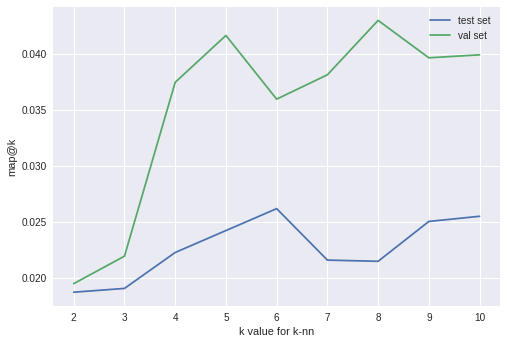

best k for test set 4
best k for validation set 6


In [0]:
# Plot the MAP@k for each k values
plt.plot(range(2,11),map_k_freq_test)
plt.plot(range(2,11),map_k_freq_val)
plt.legend(['test set','val set'])
plt.ylabel('map@k')
plt.xlabel('k value for k-nn')
plt.show()
print('best k for test set',np.argmax(map_k_freq_test))
print('best k for validation set',np.argmax(map_k_freq_val))

As shown in the plot the best k for the validation set and test set are different.

Which k should we use for our model? Why?

**Ans:**

Why do you think the best k for the validation set and test set are different? It is important that the validation and test set comes from similar distributions so that we can choose the appropriate k for our model.

** Ans: **

Suggest a better way to split the test and validation set, so that the two sets come from similar distribution.

**Ans:**

# Product segmentation using k-means

In the next part of the lab, we will use k-means to properties into groups. K-mean is an unsupervised algorithm that can group data points into clusters.

We will try to group the properties using different set of features and learn about the precularities of the k-mean algorithm through them.

## K-mean using project features

First we will use k-mean on project features: lat, lon, starting price.

Create a feature matrix using the entire project_main. The rows refer to different projects.


<details>
    <summary>SOLUTION HERE!</summary>
  <pre>
  <code>
project_main_np_data  = np.array(project_main[["lat","lon","starting_price"]].values)
  </code>
  </pre>
</details>


We also provide location data for the mass transit systems in Bangkok (MRT, BTS, ARL), which we will use to help visualize our data.

In [0]:
mass_transit = pd.read_csv('https://raw.githubusercontent.com/Pataweepr/applyML_vistec_2019/master/data/BKK_metro_data_2019.csv')
mass_transit_np_data  = np.array(mass_transit[["lat","lon"]].values)
mass_transit.head()

,Unnamed: 0,color,lat,lon,name,route,serviceend,servicestart,yearopened
0,BLL07,rail,13.789113,100.574126,สุทธิสาร,BL,24:00,6:00,2004
1,GRL19,rail,13.772430,100.542058,สนามเป้า,GR,24:00,5:30,1999
2,PPL08,rail,13.865830,100.494604,แยกนนทบุรี1,PP,24:00,6:00,2015
3,BRT07,rail,13.682329,100.525417,วัดดอกไม้,BR,24:00,6:00,2010
4,PPL13,rail,13.829542,100.526946,วงศ์สว่าง,PP,24:00,6:00,2015


### TODO#3: Visualize projects on a map

Plot the projects and the transit locations onto x,y coordinates. Which should be the x coordinate latitude or longitude? Compare it to the map of Bangkok shown below.

![Bangkok](https://www.img.in.th/images/02f4f215d503eca7777857e07f6a2b54.md.png)

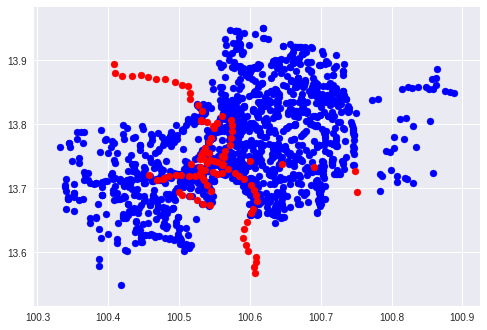

In [0]:
# Code here, it should look something like below

<details>
    <summary>SOLUTION HERE!</summary>
  <pre>
  <code>
plt.scatter(project_main_np_data[:,1], project_main_np_data[:,0], c='blue', marker='o')
plt.scatter(mass_transit_np_data[:,1], mass_transit_np_data[:,0], c='red', marker='o')
plt.show()
  </code>
  </pre>
</details>

### TODO#4: Apply k-means

Apply [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) using number of cluster = 10.

You can look at examples of k-means usage [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html)

Keep the results in variable name *kmean_result*.





<details>
    <summary>SOLUTION HERE!</summary>
  <pre>
  <code>
kmean_result =  KMeans(n_clusters = 10).fit(project_main_np_data)
  </code>
  </pre>
</details>

Plot the kmean_result as a map using the labels in kmean_result to use different colors. Use the code below to plot the results.

In [0]:
# This part is code that generate different colors for each cluster.
# It is done by varying r g b values.
# The list of colors is stored in the list colors.
a = np.arange(0,256,int(256/5))
list_base_16 = []
for num in a:
  base_16 = hex(num).split('x')[-1]
  if len(base_16) == 1:
    base_16 = '0' + base_16
  list_base_16.append(base_16)
colors = []
for r in list_base_16:
  for g in list_base_16:
    for b in list_base_16:
      if(r!=g and g!=b and b!=r):
        colors.append('#' + r + g + b)

In [0]:
# plot each cluster
for i in np.arange(project_main_np_data.shape[0]):
  plt.scatter(project_main_np_data[i,1], project_main_np_data[i,0],c=colors[kmean_result.labels_[i]], marker='o')
#Uncomment to also plot mass transit locations
#plt.scatter(mass_transit_np_data[:,1], mass_transit_np_data[:,0], c='red', marker='o')
plt.show()

The results of k-means depend on the initial starting point. Try running k-means twice and visualize the difference.


In [0]:
# Code here

We can set the seed for the random initialization with the parameter *random_state*. From now on we will use *random_state=30*.

Observe the clusters. K-mean groups projects from various places together. can you explain why the cluster came out this way?

** Ans: **

### TODO#5: Apply k-means with normalized features

To fix the error from the previous section, we should normalize the features to 0 and 1 first.

Redo the clustering and plot the clusters using normalized features.

In [0]:
# Code here

Explain why the cluster turns out this way

** Ans: **

### TODO#6: Varying k

K-means just like k-nn has a hyperparameter k that you can select. However, picking the best k is not so straightforward since there is no one single objective criterion to use (In our k-nn example we use MAP@k). 

Note: some people use cluster purity or the elbow method to select k. However, in this case we will just look using our eyes.

Vary the value of k from 5,15,25,...,55 and visualize the results.


Can you observe clustering that is based on more than just locational data? Try zooming into BTS locations.

### TODO#7: Clustering based on binary views matrix

We can also cluster the projects based on other kinds of features. Try clustering using the binary views of each user (whether or not a user view the project) and visualize the results for k = 5 and 50.

Don't forget to filter out projects that has no views.

Do you get anything meaningful?

In [0]:
# Code here

<details>
    <summary>SOLUTION HERE!</summary>
  <pre>
  <code>
freq_user_seen_proj = pd.crosstab(userLog['project_id'], userLog['userCode'], rownames=['project_id'], colnames=['userCode'])
freq_user_seen_proj_np = np.array(freq_user_seen_proj.values > 0)

project_main_seen = project_main.loc[project_main['project_id'].isin(freq_user_seen_proj.index.astype(int))]
project_main_seen_np_data  = np.array(project_main_seen[["lat","lon","starting_price"]].values)

#Need extra code to perform kmean
  </code>
  </pre>
</details>

The problem with this clustering is that each projects has too little views from distinct users.

Try filtering the out projects with less than 10 distinct users, and filter users that has less than 10 distinct views. Then, try k = 120.

You might find it helpful to remove the biggest cluster from the plot (the cluster with the largest amount of members).


In [0]:
# Code here

The data provided is too small, and our compute is too small to get nice results. However, below are some example cluters from bigger data with bigger machines. Notice how the clusters can go beyond simple lat-long coordinates, especially in the last picture where the top and bottom parts belong to the same cluster. This is because the two regions have similar travel time to inner bangkok and have around the same price range, so a large group of people consider both regions. This is something that is not obvious until we look into the data.

This is the power of collaborative filtering.


Groups following the rail lines. (Including the new line underconstruction)
![alt text](https://github.com/Pataweepr/applyML_vistec_2019/raw/master/data/figs/Screenshot%202018-03-30%2011.31.39.png)

Groups in Pattaya. The cluster at near Pattaya beaches also appears in Hua Hin.
![alt text](https://github.com/Pataweepr/applyML_vistec_2019/raw/master/data/figs/Screenshot%202018-03-30%2012.39.36.png)

The BTS lines are grouped heavily
![alt text](https://github.com/Pataweepr/applyML_vistec_2019/raw/master/data/figs/Screenshot%202018-03-30%2017.29.10.png)

A splitted group
![alt text](https://github.com/Pataweepr/applyML_vistec_2019/raw/master/data/figs/Screenshot%202018-03-30%2019.19.04.png)